# Statistical Methods for High Dimensional Biology (STAT/BIOF/GSAT 540)



# Lecture 5: Two-group Comparisons and Statistical Inference

# Overview
In this lecture, you will learn about ...

### Learning Objectives:
- 1
- 2
- 3

### R Dependencies:

- lattice
- latticeExtra
- RColorBrewer

In [1]:
library(knitr)
knitr::opts_knit$set(root.dir=".")

library(lattice)
library(latticeExtra)

jCols <- c(x = "blue", y = "orange")
trellis.par.set(superpose.symbol = list(col = jCols),
                superpose.line = list(col = jCols))
jCex <- 3

Warning message:
"package 'knitr' was built under R version 3.4.4"Warning message:
"package 'latticeExtra' was built under R version 3.4.3"Loading required package: RColorBrewer


# Data description

We will be using the dataset from [SOURCE]

This dataset entails ...

# Loading the data

In [2]:
prDes <- readRDS("data/GSE4051_design.rds")
str(prDes)

'data.frame':	39 obs. of  4 variables:
 $ sidChar : chr  "Sample_20" "Sample_21" "Sample_22" "Sample_23" ...
 $ sidNum  : num  20 21 22 23 16 17 6 24 25 26 ...
 $ devStage: Factor w/ 5 levels "E16","P2","P6",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ gType   : Factor w/ 2 levels "wt","NrlKO": 1 1 1 1 2 2 2 1 1 1 ...
'data.frame':	29949 obs. of  39 variables:
 $ Sample_20: num  7.24 9.48 10.01 8.36 8.59 ...
 $ Sample_21: num  7.41 10.02 10.04 8.37 8.62 ...
 $ Sample_22: num  7.17 9.85 9.91 8.4 8.52 ...
 $ Sample_23: num  7.07 10.13 9.91 8.49 8.64 ...
 $ Sample_16: num  7.38 7.64 8.42 8.36 8.51 ...
 $ Sample_17: num  7.34 10.03 10.24 8.37 8.89 ...
 $ Sample_6 : num  7.24 9.71 10.17 8.84 8.54 ...
 $ Sample_24: num  7.11 9.75 9.39 8.37 8.36 ...
 $ Sample_25: num  7.19 9.16 10.11 8.2 8.5 ...
 $ Sample_26: num  7.18 9.49 9.41 8.73 8.39 ...
  [list output truncated]


In [19]:
prDat<-read.table("data/GSE4051_data.tsv",
                  sep = "\t", header = T, row.names = 1)
str(prDat, list.len = 10)

'data.frame':	29949 obs. of  39 variables:
 $ Sample_20: num  7.24 9.48 10.01 8.36 8.59 ...
 $ Sample_21: num  7.41 10.02 10.04 8.37 8.62 ...
 $ Sample_22: num  7.17 9.85 9.91 8.4 8.52 ...
 $ Sample_23: num  7.07 10.13 9.91 8.49 8.64 ...
 $ Sample_16: num  7.38 7.64 8.42 8.36 8.51 ...
 $ Sample_17: num  7.34 10.03 10.24 8.37 8.89 ...
 $ Sample_6 : num  7.24 9.71 10.17 8.84 8.54 ...
 $ Sample_24: num  7.11 9.75 9.39 8.37 8.36 ...
 $ Sample_25: num  7.19 9.16 10.11 8.2 8.5 ...
 $ Sample_26: num  7.18 9.49 9.41 8.73 8.39 ...
  [list output truncated]


Here we examine the design of the study with a frequency table. We have four samples for each combination of development stage and genotype (except for "E16 and NrlKO", which has 3 samples)

In [3]:
with(prDes, table(devStage, gType))

         gType
devStage  wt NrlKO
  E16      4     3
  P2       4     4
  P6       4     4
  P10      4     4
  4_weeks  4     4

A cursory glance at the experession data reveals:

In [4]:
head(subset(prDat, select = 1:5))

,Sample_20,Sample_21,Sample_22,Sample_23,Sample_16
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1415670_at,7.236,7.414,7.169,7.070,7.383
1415671_at,9.478,10.020,9.854,10.130,7.637
1415672_at,10.010,10.040,9.913,9.907,8.423
1415673_at,8.362,8.374,8.404,8.487,8.363
1415674_a_at,8.585,8.615,8.520,8.641,8.509
1415675_at,9.591,9.719,9.709,9.700,9.656


# Subsetting the data

Nrl (neural retina leucine zipper gene) is the gene that was knocked out in half the mice, and should obviously be differentially expressed. Nrl’s probeset ID is “1450946_at”. Irs4 (insulin receptor substrate 4) is selected as a boring non-differentially expressed gene. Irs4’s probeset ID is “1422248_at”.

We extract the rows for each of these genes, transpose and then vectorize the data. We then merge this data together with the design metadata. Ensure that the samples match between the data and design before merging.

In [5]:
miniDat <- as.vector(t(prDat[c("1422248_at", "1450946_at"), ]))
miniDat <- data.frame(gene = rep(c("Irs4", "Nrl"), each = nrow(prDes)),
                      gExp = miniDat)
miniDat <- data.frame(prDes, miniDat) # ignore the warning about row names
str(miniDat)

Warning message in data.frame(prDes, miniDat):
"row names were found from a short variable and have been discarded"

'data.frame':	78 obs. of  6 variables:
 $ sidChar : chr  "Sample_20" "Sample_21" "Sample_22" "Sample_23" ...
 $ sidNum  : num  20 21 22 23 16 17 6 24 25 26 ...
 $ devStage: Factor w/ 5 levels "E16","P2","P6",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ gType   : Factor w/ 2 levels "wt","NrlKO": 1 1 1 1 2 2 2 1 1 1 ...
 $ gene    : Factor w/ 2 levels "Irs4","Nrl": 1 1 1 1 1 1 1 1 1 1 ...
 $ gExp    : num  7.87 7.78 7.58 7.4 8.08 ...


# Data visualization for two-group comparisons 

We have a few options to visualize the differences in gene expression between genotypes. In each plot, we generate a panel for each gene.

# Strip plots
One option is to examine a strip plot. The first plot allows the x-axis scale to be freely set for each gene (dependent on the range of gene expression). The second plot forces both panels to have matching x-axis scales, which allows for between gene comparisons as well. The final plot let’s us plot the mean values of gene expression for each gene and genotype.

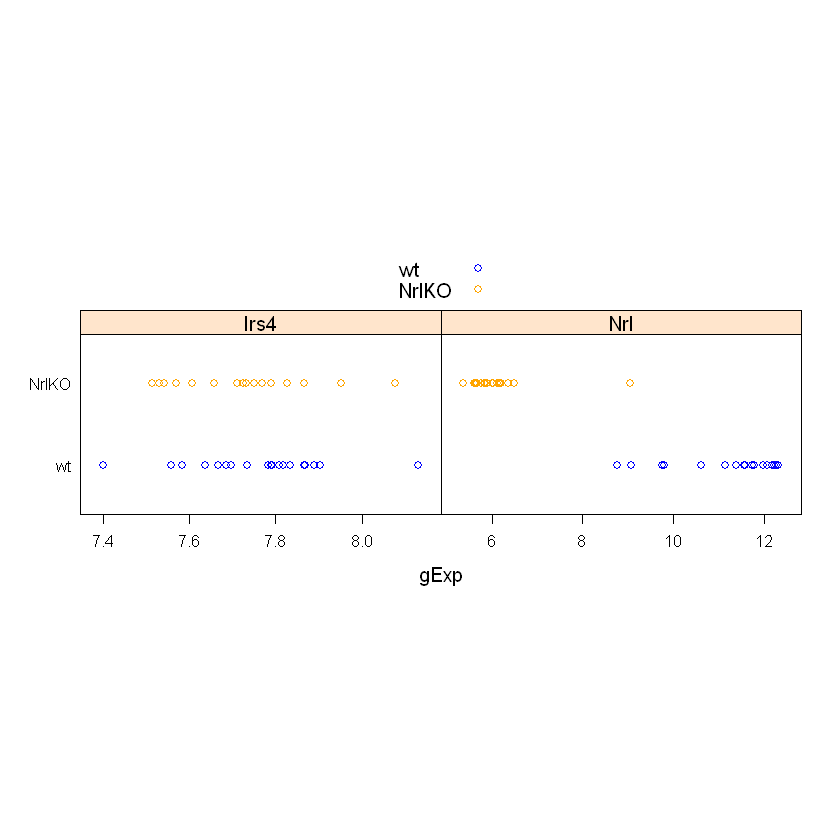

In [6]:
stripplot(gType ~ gExp | gene, miniDat,
          scales = list(x = list(relation = "free")),
          groups = gType, auto.key = TRUE,
          aspect = 0.5, layout = c(2, 1))

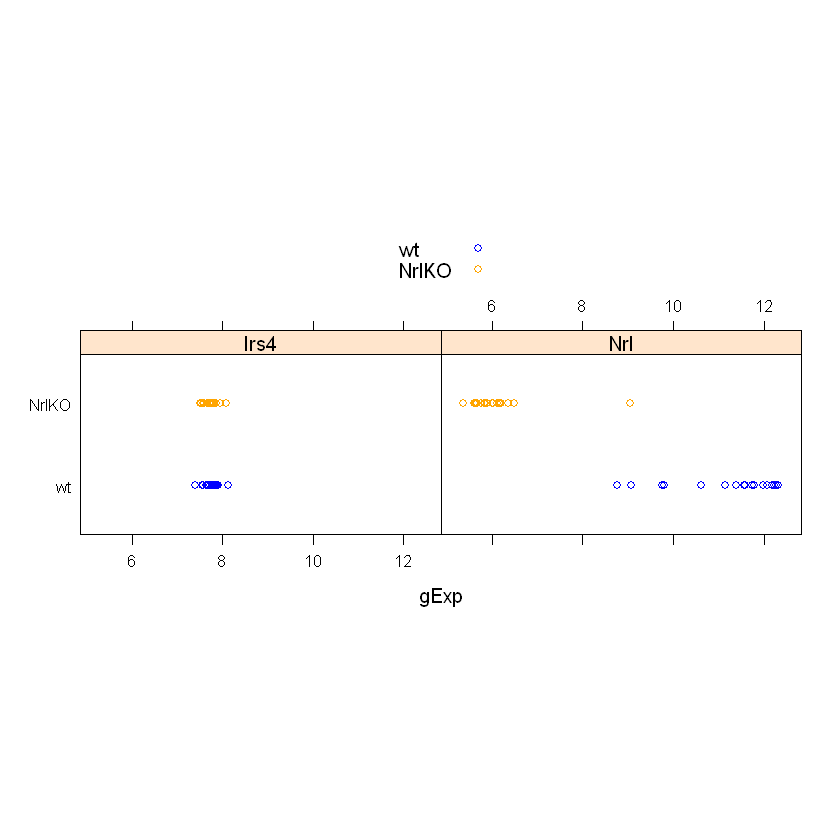

In [7]:
stripplot(gType ~ gExp | gene, miniDat,
          groups = gType, auto.key = TRUE,
          aspect = 0.5, layout = c(2, 1))

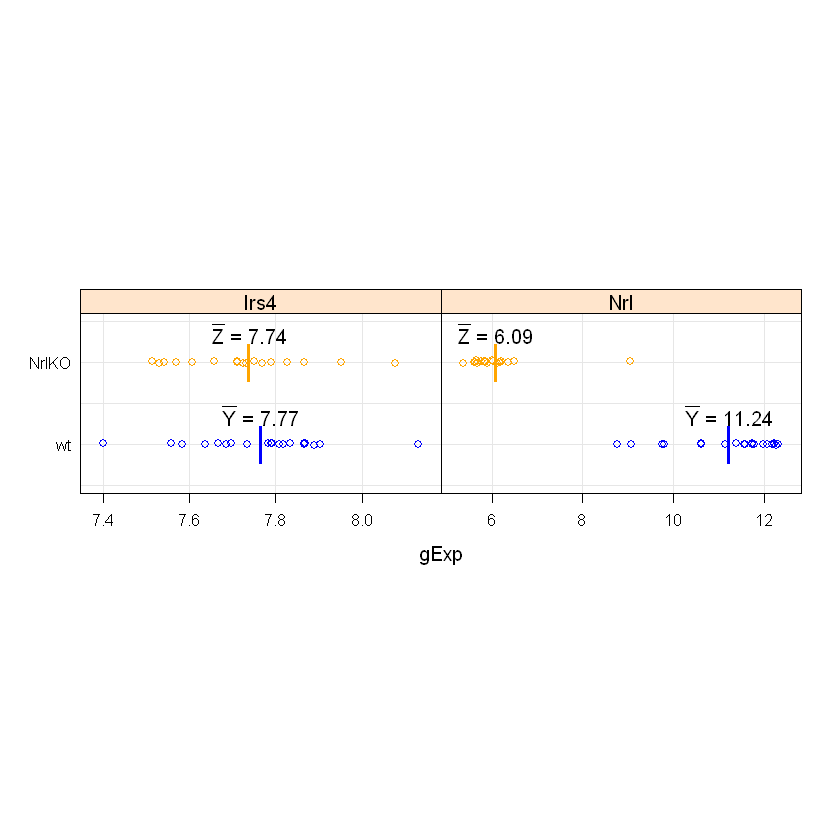

In [8]:
jFudge <- 0.35
stripplot(gType ~ gExp | gene, miniDat,
          grid = TRUE,
          scales = list(x = list(relation = "free")),
          groups = gType, jitter.data = TRUE,
          aspect = 0.5, layout = c(2, 1),
          panel = panel.superpose,
          panel.groups = function(x, y, ..., group.number) {
            yo <- group.number
            panel.stripplot(x, y, ...)
            theAvg <- mean(x)
            panel.points(theAvg, y[1], pch = "|", cex = jCex,
                         col = jCols[group.number])
            jLab <- substitute(paste(bar(Z), " = ", foo),
                        list(Z = c("Y", "Z")[group.number],
                             foo = round(theAvg, 2)))
            panel.text(x = mean(x), y = y[1] + jFudge,
                       jLab)
          })

# Density plots
Another option is to examine a density plot. This plot let's us observe the distributions of gene expression, and how these distributions compare across genotype. The second plot is a "violin" plot, which provides a similar visualization as the density plot.

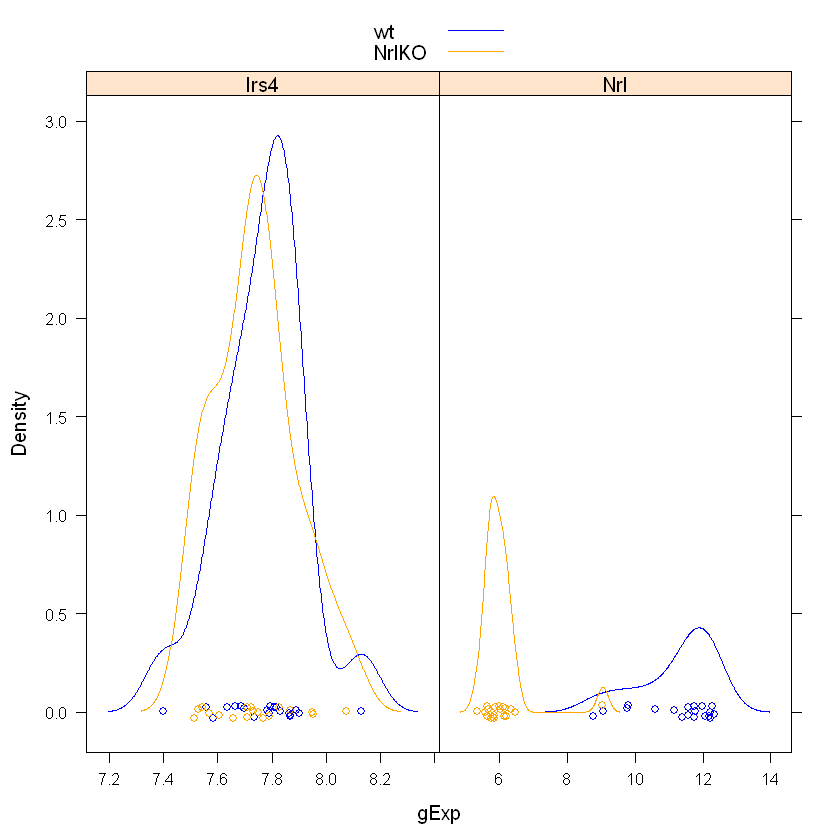

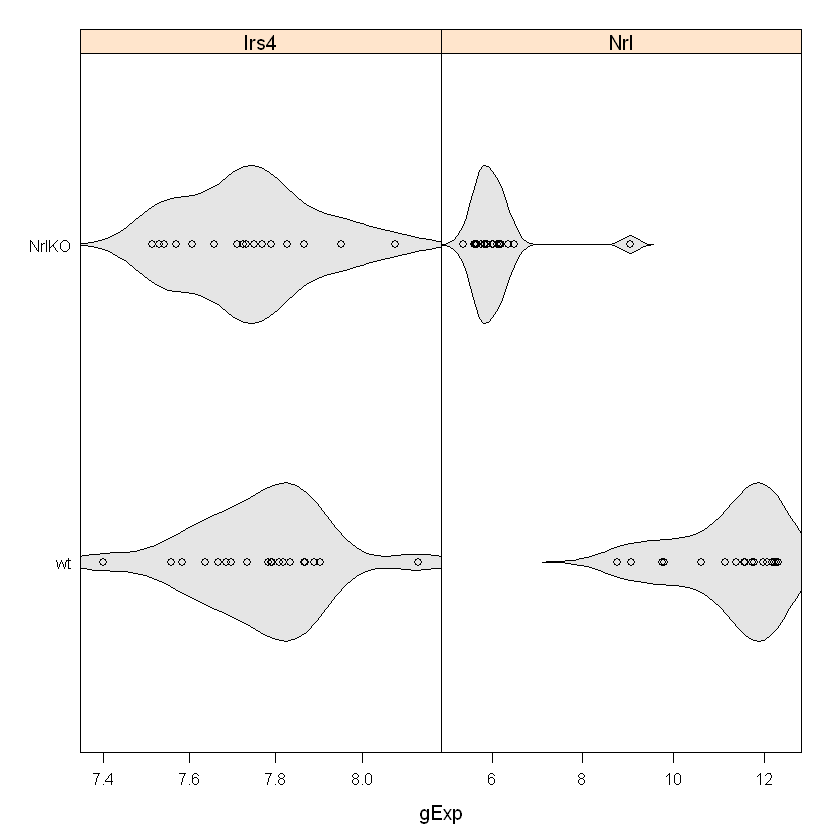

In [9]:
densityplot(~ gExp | gene, miniDat,
            scales = list(x = list(relation = "free")),
            groups = gType, auto.key = TRUE)

bwplot(gType ~ gExp | gene, miniDat,
       scales = list(x = list(relation = "free")),
       panel = function(...) {
         panel.violin(..., col = "grey90")
         panel.stripplot(..., col = "black")
       })

# Boxplots
Boxplots may be another good choice. We can observe the median and IQR of our group distributions, as well as identify any outliers. The second plot combines a boxplot together with a "violin" plot.

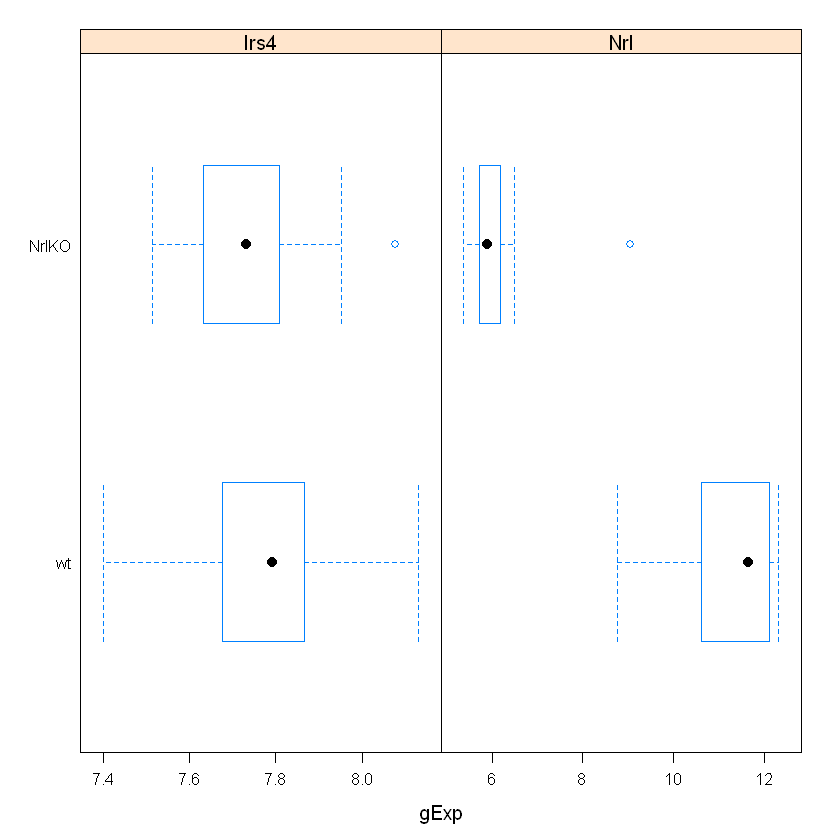

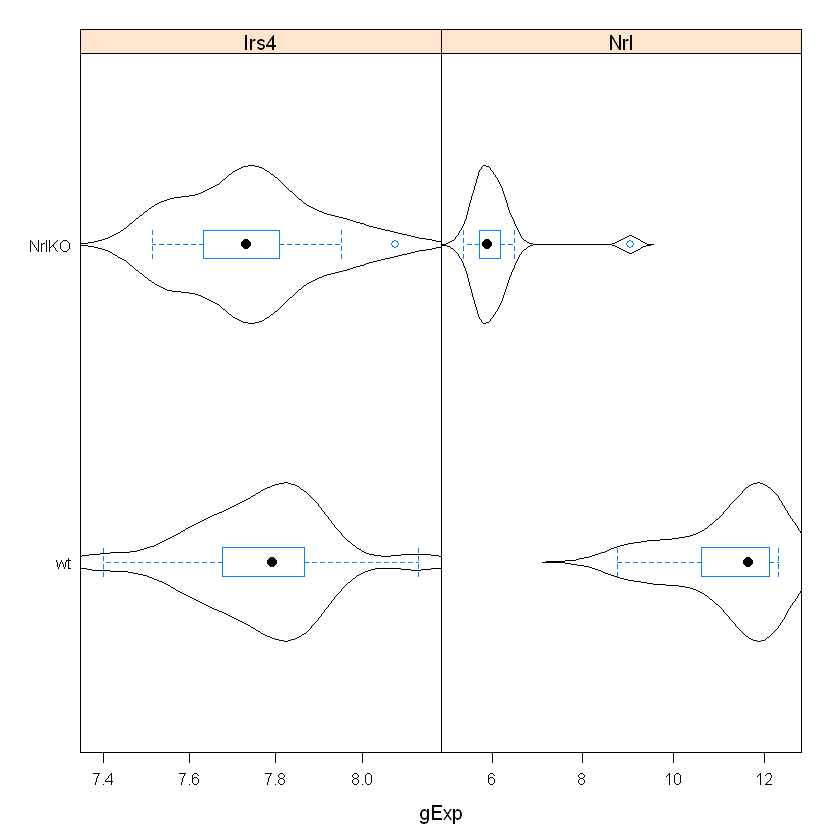

In [10]:
bwplot(gType ~ gExp | gene, miniDat,
       scales = list(x = list(relation = "free")))

bwplot(gType ~ gExp | gene, miniDat,
       scales = list(x = list(relation = "free")),
       panel = function(..., box.ratio) {
         panel.violin(..., col = "transparent", border = "black",
                      varwidth = FALSE, box.ratio = box.ratio)
         panel.bwplot(..., fill = NULL, box.ratio = .1)
       })

# Statistical Inference

# Two-group inference: t-tests

Now we're interested in testing whether we see a significant difference in mean gene expression between the wildtype and the NrlKO genotype. One option is to use a "two sample" t-test (sample here refers to the groups, not the individual samples). We compute the sample means for each genotype, for the two genes of interest. We then obtain the sample mean differences between wildtype and NrlKO for each gene. 

In [11]:
## compute difference of sample averages
(theAvgs <- with(miniDat,
                 tapply(gExp, list(gType, gene), mean)))

(theDiff <- theAvgs["NrlKO", ] - theAvgs["wt", ])

,Irs4,Nrl
wt,7.765750,11.244200
NrlKO,7.739684,6.089632


Irs4         Nrl 
-0.02606579 -5.15456842

Next, we compute the estimated variance of the difference between group sample means. We have two options here. One is that we can assume that the population variances of the two groups (the populations here being the wildtype and the NrlKO populations) are either inequivalent or equivalent. The following code computes both. The unequal variances option corresponds to the "Welch" two sample t-test.

In [12]:
## compute sample variances
(theVars <- with(miniDat,
                 tapply(gExp, list(gType, gene), var)))

## compute estimated variance of zbar - ybar
(nY <- with(miniDat, sum(gType == "wt" & gene == "Nrl")))
(nZ <- with(miniDat, sum(gType == "NrlKO" & gene == "Nrl")))

## assuming unequal true variance
(s2DiffWelch <- colSums(theVars / c(nY, nZ)))

## assuming equal true variance
(s2Pooled <- colSums(theVars * c((nY - 1) / (nY + nZ - 2),
                                 (nZ - 1) / (nY + nZ - 2))))

(s2Diff <- s2Pooled * (1/nY + 1/nZ))

,Irs4,Nrl
wt,0.02403557,1.2243331
NrlKO,0.02332078,0.5942802


[1] 20

[1] 19

Irs4         Nrl 
0.002429188 0.092494563

Irs4        Nrl 
0.02368783 0.91782091

Irs4        Nrl 
0.00243112 0.09419741

With the difference in means and our estimate of the variance of the difference between group sample means, we can compute the test statistic. In R, we can use the "t.test" function to compute the test statistic and perform the test for us. Our first tests are the Welch two-sample t-tests (in which we assume unequal group variances), and their results for both Irs4 and Nrl are shown below. Recall that our null hypothesis is that there is no difference in the sample means between the two groups. For each given test, we get a p-value for the test statistic based on the null sampling distribution. Notably, the tests corresponding to the Irs4 gene and Nrl gene have p-values of 0.6001 and nearly 0, respectively. This suggests a statistically significant difference in mean gene expression for Nrl, but not for Irs4.

In [13]:
(welchStat <- theDiff / sqrt(s2DiffWelch))

by(miniDat, miniDat$gene, function(theDat) {
  ## to be compatible with the direction of the test, as I've described in
  ## lecture slides, I need to reverse order of levels of gType factor
  theDat$gType <- factor(theDat$gType, rev(levels(theDat$gType)))
  t.test(gExp ~ gType, theDat)
})

Irs4         Nrl 
 -0.5288595 -16.9486146

miniDat$gene: Irs4

	Welch Two Sample t-test

data:  gExp by gType
t = -0.52886, df = 36.948, p-value = 0.6001
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1259351  0.0738035
sample estimates:
mean in group NrlKO    mean in group wt 
           7.739684            7.765750 

------------------------------------------------------------ 
miniDat$gene: Nrl

	Welch Two Sample t-test

data:  gExp by gType
t = -16.949, df = 34.005, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.772630 -4.536507
sample estimates:
mean in group NrlKO    mean in group wt 
           6.089632           11.244200 


We perform the same tests, but this time assuming that the group variances are equal. The results are very similar. The test we choose to perform will depend on which assumption we want to make about the distributions of the group populations.

In [14]:
(tstStat <- theDiff / sqrt(s2Diff))

by(miniDat, miniDat$gene, function(theDat) {
  theDat$gType <- factor(theDat$gType, rev(levels(theDat$gType)))
  t.test(gExp ~ gType, theDat, var.equal = TRUE)
})

Irs4         Nrl 
 -0.5286494 -16.7947224

miniDat$gene: Irs4

	Two Sample t-test

data:  gExp by gType
t = -0.52865, df = 37, p-value = 0.6002
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.12597002  0.07383844
sample estimates:
mean in group NrlKO    mean in group wt 
           7.739684            7.765750 

------------------------------------------------------------ 
miniDat$gene: Nrl

	Two Sample t-test

data:  gExp by gType
t = -16.795, df = 37, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.776439 -4.532698
sample estimates:
mean in group NrlKO    mean in group wt 
           6.089632           11.244200 


Here we have the null distribution, where we overlay the t-distribution (red dotted line) with 37 degrees of freedom on top of the normal distribution (black line). In the subsequent plot, we examine the test statistic for Irs4 and where it lies on the distribution. The highlighted areas in blue is a visualization of our p-value, our measure of how likely we are to see a test statistic as or more extreme than what we observed.

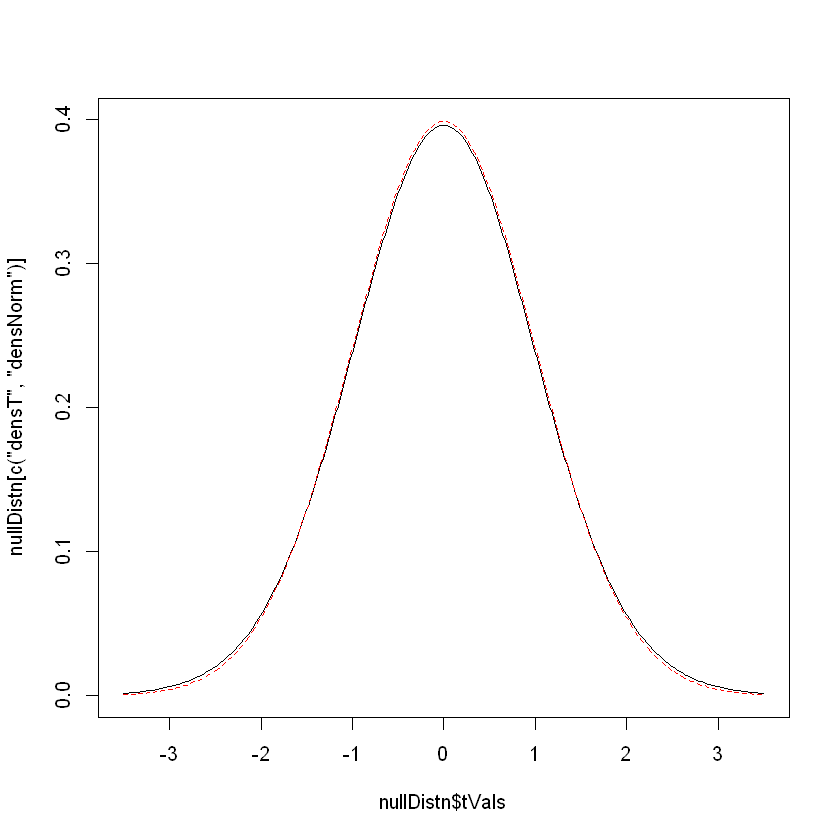

Irs4     Nrl 
0.60021 0.00000

Irs4     Nrl 
0.59705 0.00000

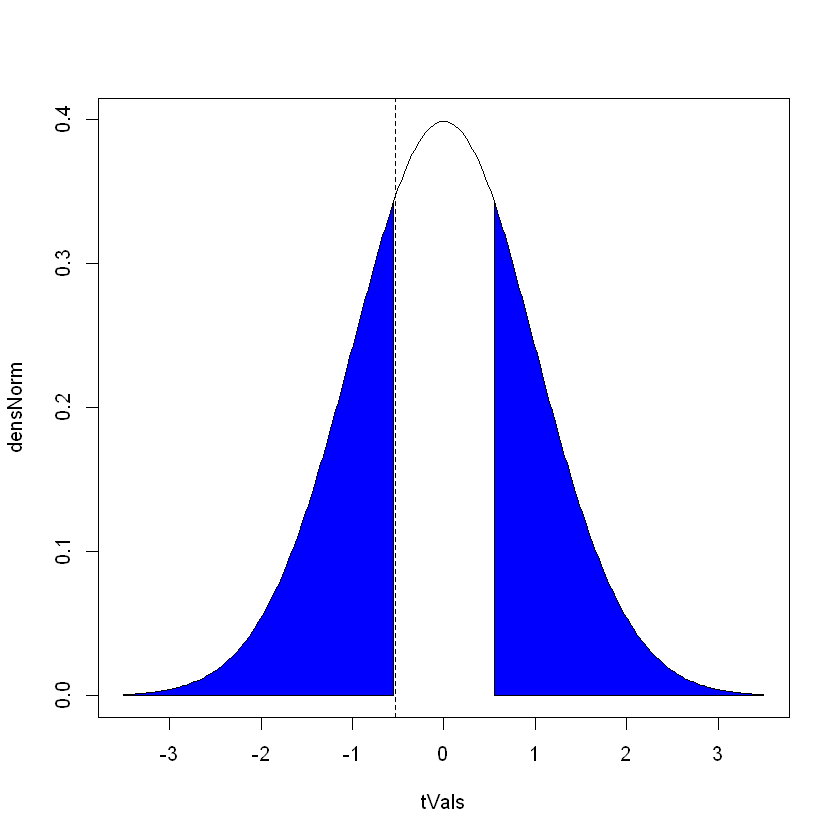

In [15]:
## draw the null dist'n

nullDistn <- data.frame(tVals = seq(-3.5, 3.5, length = 300))
nullDistn$densT <- dt(nullDistn$tVals, df = nY + nZ - 2)
nullDistn$densNorm <- dnorm(nullDistn$tVals)

with(nullDistn,
     matplot(x = nullDistn$tVals,
             y = nullDistn[c("densT", "densNorm")],
             type = "l"))

## depicting only for Irs4!

with(nullDistn,
     plot(densNorm ~ tVals, type = "l"))
abline(v = tstStat["Irs4"], lty = "dashed")

foo <- subset(nullDistn, tVals < tstStat["Irs4"])
polygon(x = c(foo$tVals, rev(foo$tVals)),
        y = c(rep(0, nrow(foo)), rev(foo$densNorm)),
        col = "blue")

polygon(x = -1 * c(foo$tVals, rev(foo$tVals)),
        y = c(rep(0, nrow(foo)), rev(foo$densNorm)),
        col = "blue")

round(pt(-1 * abs(tstStat), df = nY + nZ - 2) * 2, 5)
round(pnorm(-1 * abs(tstStat)) * 2, 5)

# Two-group inference: Wilcoxon Rank Test

Another option to compare the distributions of gene expression between two groups is the Wilcoxon Rank Test. 

In [16]:
(wilcTest <- by(miniDat, miniDat$gene, function(theDat) {
    wilcox.test(gExp ~ gType, theDat)
}))

## Warning messages:
## 1: In wilcox.test.default(x = c(7.867, 7.783, 7.585, 7.4, 7.667, 7.818,  :
##   cannot compute exact p-value with ties
## 2: In wilcox.test.default(x = c(8.761, 9.079, 10.61, 9.796, 11.39,  :
##   cannot compute exact p-value with ties

## hmmm..... there are *ties*? really?
by(miniDat, miniDat$gene, function(theDat) rank(theDat$gExp))
## yep, sure are, for both Irs4 and Nrl .... strange

## let's recreate the Wilcoxon test statistic
(jRankSums <- by(miniDat, miniDat$gene, function(theDat) {
    tapply(rank(theDat$gExp), theDat$gType, sum)
}))

(sampSize <- c(nY, nZ))

## from wilcox.text, we learn this: "The literature is not unanimous
## about the definitions of the Wilcoxon rank sum and Mann-Whitney
## tests.  The two most common definitions correspond to the sum of
## the ranks of the first sample with the minimum value subtracted or
## not: R subtracts and S-PLUS does not, giving a value which is
## larger by m(m+1)/2 for a first sample of size m."

sapply(jRankSums, function(foo) foo - sampSize * (sampSize + 1)/2)

## focus on the first row of that table -- the rank sums for wild type
## with the associated minimum subtracted

sapply(wilcTest, function(foo) foo$stat)

## Compare to output of the "official" test.
## See! we've computed the test statistic for ourselves.

Warning message in wilcox.test.default(x = c(7.867, 7.783, 7.585, 7.4, 7.667, 7.818, :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(x = c(8.761, 9.079, 10.61, 9.796, 11.39, :
"cannot compute exact p-value with ties"

miniDat$gene: Irs4

	Wilcoxon rank sum test with continuity correction

data:  gExp by gType
W = 220.5, p-value = 0.3992
alternative hypothesis: true location shift is not equal to 0

------------------------------------------------------------ 
miniDat$gene: Nrl

	Wilcoxon rank sum test with continuity correction

data:  gExp by gType
W = 379, p-value = 1.178e-07
alternative hypothesis: true location shift is not equal to 0


miniDat$gene: Irs4
 [1] 31.5 22.0  7.0  1.0 38.0  2.0 37.0 11.0 27.0 35.0 13.0 28.0 36.0 16.0 24.0
[16] 39.0 12.0 18.0 34.0 10.0  8.0  3.0  4.0 29.0  9.0 23.0 30.0 21.0 19.0 31.5
[31] 14.5 33.0 25.0  5.0 26.0 17.0 14.5  6.0 20.0
------------------------------------------------------------ 
miniDat$gene: Nrl
 [1] 19.0 21.0 24.5 23.0 15.0  9.0  1.0 27.0 24.5 28.0 22.0  8.0  5.0 14.0 17.0
[16] 26.0 34.0 29.0 30.5 16.0 12.0 13.0 18.0 35.0 33.0 30.5 32.0 10.0  7.0  3.0
[31] 11.0 37.0 38.0 39.0 36.0  2.0  4.0  6.0 20.0

miniDat$gene: Irs4
   wt NrlKO 
430.5 349.5 
------------------------------------------------------------ 
miniDat$gene: Nrl
   wt NrlKO 
  589   191 

[1] 20 19

,Irs4,Nrl
wt,220.5,379
NrlKO,159.5,1


Irs4.W  Nrl.W 
 220.5  379.0

Warning message in ks.test(x = theDat$gExp[theDat$gType == "wt"], y = theDat$gExp[theDat$gType == :
"cannot compute exact p-value with ties"Warning message in ks.test(x = theDat$gExp[theDat$gType == "wt"], y = theDat$gExp[theDat$gType == :
"cannot compute exact p-value with ties"

miniDat$gene: Irs4

	Two-sample Kolmogorov-Smirnov test

data:  theDat$gExp[theDat$gType == "wt"] and theDat$gExp[theDat$gType == "NrlKO"]
D = 0.28421, p-value = 0.4107
alternative hypothesis: two-sided

------------------------------------------------------------ 
miniDat$gene: Nrl

	Two-sample Kolmogorov-Smirnov test

data:  theDat$gExp[theDat$gType == "wt"] and theDat$gExp[theDat$gType == "NrlKO"]
D = 0.95, p-value = 4.603e-08
alternative hypothesis: two-sided


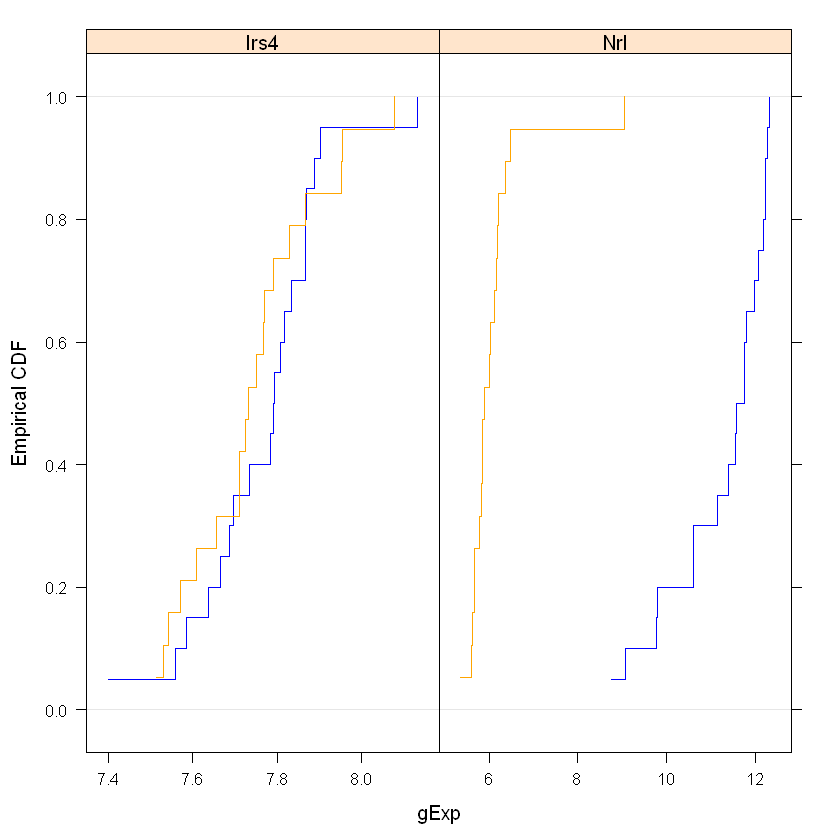

In [17]:
###############################################
## "two groups" inference: Kolmogorov-Smirnov
###############################################

## sadly, ks.test() has no formula interface

(ksTest <- by(miniDat, miniDat$gene, function(theDat) {
    ks.test(x = theDat$gExp[theDat$gType == "wt"],
            y = theDat$gExp[theDat$gType == "NrlKO"])
}))
## more moaning about the ties


## fodder for recreating the KS test stat by hand ... leaving for now
## THIS CODE WILL NOT WORK 'AS IS'!!

## foo <- ecdf(miniDat$gExp)

## x <- rnorm(12)
## Fn <- ecdf(x)
## Fn     # a *function*
## Fn(x)  # returns the percentiles for x
## tt <- seq(-2,2, by = 0.1)
## 12 * Fn(tt) # Fn is a 'simple' function {with values k/12}
## summary(Fn)
## ##--> see below for graphics
## knots(Fn)# the unique data values {12 of them if there were no ties}
## plot(tt, Fn(tt))

ecdfplot(~ gExp | gene, miniDat,
         scales = list(x = list(relation = "free")),
          groups = gType)

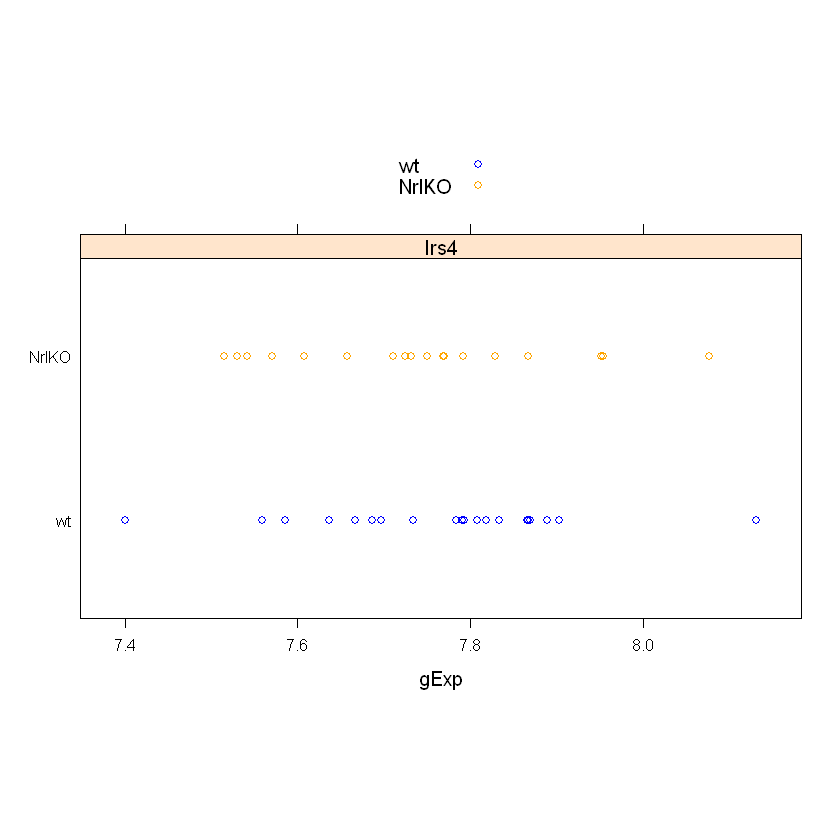


	Two Sample t-test

data:  gExp by gType
t = 0.52865, df = 37, p-value = 0.6002
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07383844  0.12597002
sample estimates:
   mean in group wt mean in group NrlKO 
           7.765750            7.739684 


            Df Sum Sq Mean Sq F value Pr(>F)
gType        1 0.0066 0.00662   0.279    0.6
Residuals   37 0.8764 0.02369               


Call:
lm(formula = gExp ~ gType, data = miniDat, subset = gene == "Irs4")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36575 -0.09072  0.01725  0.09428  0.36525 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.76575    0.03441 225.650   <2e-16 ***
gTypeNrlKO  -0.02607    0.04931  -0.529      0.6    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1539 on 37 degrees of freedom
Multiple R-squared:  0.007497,	Adjusted R-squared:  -0.01933 
F-statistic: 0.2795 on 1 and 37 DF,  p-value: 0.6002


,Irs4,Nrl
wt,7.765750,11.244200
NrlKO,7.739684,6.089632


[1] -0.026066

t 
0.5286494

[1] 0.2794702

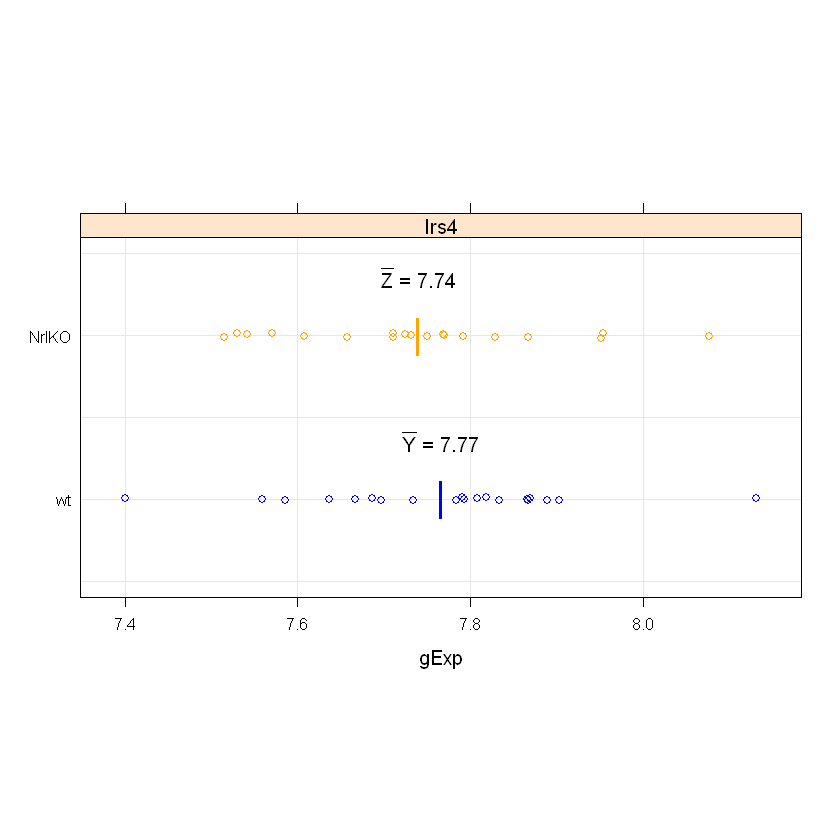

In [18]:
###############################################
## direct support of first little bit of "beyond two groups" lecture
###############################################

## stripplot **for Irs4** by itself
stripplot(gType ~ gExp | gene, miniDat,
          subset = gene == "Irs4",
          groups = gType, auto.key = TRUE,
          aspect = 0.5)

## stripplot with sample means **for Irs4** by itself
jFudge <- 0.35
stripplot(gType ~ gExp | gene, miniDat,
          subset = gene == "Irs4",
          grid = TRUE, aspect = 0.5,
          groups = gType, jitter.data = TRUE,
          panel = panel.superpose,
          panel.groups = function(x, y, ..., group.number) {
            yo <- group.number
            panel.stripplot(x, y, ...)
            theAvg <- mean(x)
            panel.points(theAvg, y[1], pch = "|", cex = jCex,
                         col = jCols[group.number])
            jLab <- substitute(paste(bar(Z), " = ", foo),
                        list(Z = c("Y", "Z")[group.number],
                             foo = round(theAvg, 2)))
            panel.text(x = mean(x), y = y[1] + jFudge,
                       jLab)
          })

t.test(gExp ~ gType, miniDat,
       subset = gene == "Irs4", var.equal = TRUE)

summary(aov(gExp ~ gType, miniDat,
            subset = gene == "Irs4"))

summary(lm(gExp ~ gType, miniDat,
           subset = gene == "Irs4"))

## for pasting into slides
theAvgs
7.739684 - 7.765750
t.test(gExp ~ gType, miniDat,
       subset = gene == "Irs4", var.equal = TRUE)$stat
0.5286494 ^ 2